In [ ]:
!pip install pandas numpy scipy seaborn matplotlib scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class CollegeSuccessAnalysis:
    def __init__(self, data):
        """Initialize analyzer with DataFrame or file path."""
        if isinstance(data, str):
            try:
                self.raw_data = pd.read_csv(data)
                print("Successfully loaded CSV file")
                print(f"Number of rows: {len(self.raw_data)}")
                print(f"Number of columns: {len(self.raw_data.columns)}")
            except Exception as e:
                print(f"Error loading data: {str(e)}")
                raise
        else:
            self.raw_data = data.copy()

        self.data = None

    def prepare_data(self):
        """Clean and prepare the dataset for analysis."""
        print("Preparing and cleaning data...")

        try:
            df = self.raw_data.copy()

            # 1. Essential columns check
            required_columns = [
                'state', 'ownership', 'admission', 'completion', 'retention',
                'med_10yr_salary', 'pell_grant', 'undergrad_pop', 'ft_faculty',
                'spend_per_student', 'revenue_per_student', 'default_3yr_rate'
            ]

            missing_cols = [col for col in required_columns if col not in df.columns]
            if missing_cols:
                print(f"Warning: Missing essential columns: {missing_cols}")

            # 2. Fix data types and scaling
            # Handle percentage columns
            percentage_cols = ['completion', 'retention', 'admission', 'pell_grant',
                            'default_3yr_rate', 'race_white', 'race_black',
                            'race_hispanic', 'race_asian', 'race_native',
                            'race_pacific', 'race_other']

            for col in percentage_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    # Convert to decimal if in percentage format
                    if df[col].mean() > 1:
                        df[col] = df[col] / 100
                        print(f"Converted {col} to decimal format")

            # Handle financial columns
            financial_cols = ['med_10yr_salary', 'spend_per_student',
                            'revenue_per_student', 'tuition', 'cost']

            for col in financial_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    # Convert cents to dollars if needed
                    if df[col].mean() > 10000:
                        df[col] = df[col] / 100
                        print(f"Converted {col} to dollars")

            # 3. Create derived metrics
            # Student-Faculty Ratio
            if all(col in df.columns for col in ['undergrad_pop', 'ft_faculty']):
                df['student_faculty_ratio'] = df['undergrad_pop'] / df['ft_faculty'].clip(lower=1)
                print("Created student-faculty ratio")

            # Financial Efficiency Metrics
            if all(col in df.columns for col in ['revenue_per_student', 'spend_per_student']):
                df['revenue_cost_ratio'] = df['revenue_per_student'] / df['spend_per_student'].clip(lower=1)
                df['investment_level'] = pd.qcut(df['spend_per_student'],
                                              q=4,
                                              labels=['Low', 'Medium-Low',
                                                      'Medium-High', 'High'])
                print("Created financial efficiency metrics")

            # Diversity Index
            race_columns = ['race_white', 'race_black', 'race_hispanic',
                          'race_asian', 'race_native', 'race_pacific', 'race_other']

            available_race_cols = [col for col in race_columns if col in df.columns]
            if available_race_cols:
                # Calculate Simpson's diversity index
                df['diversity_index'] = 1 - sum(df[col]**2 for col in available_race_cols)
                print("Created diversity index")

            # Accessibility Score
            if all(col in df.columns for col in ['pell_grant', 'admission']):
                df['accessibility_score'] = (df['pell_grant'] + (1 - df['admission'])) / 2
                print("Created accessibility score")

            # Success Score
            success_metrics = ['completion', 'retention', 'med_10yr_salary']
            if all(metric in df.columns for metric in success_metrics):
                # Standardize each metric
                standardized_metrics = pd.DataFrame()
                for metric in success_metrics:
                    mean = df[metric].mean()
                    std = df[metric].std()
                    standardized_metrics[metric] = (df[metric] - mean) / std

                # Calculate composite score
                df['success_score'] = standardized_metrics.mean(axis=1)
                print("Created composite success score")

            # 4. Handle missing values
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if df[col].isnull().any():
                    # Calculate robust statistics
                    median = df[col].median()
                    mad = stats.median_abs_deviation(df[col].dropna(), scale='normal')

                    # Fill missing values
                    df[col] = df[col].fillna(median)

                    # Remove extreme outliers (beyond 5 MADs)
                    mask = abs(df[col] - median) > 5 * mad
                    df.loc[mask, col] = median

                    print(f"Handled missing values and outliers in {col}")

            # 5. Filter invalid data
            # Remove institutions with zero or negative essential metrics
            essential_positive = ['undergrad_pop', 'spend_per_student',
                                'revenue_per_student']
            for col in essential_positive:
                if col in df.columns:
                    df = df[df[col] > 0]

            # Remove institutions with impossible percentages
            percentage_cols = [col for col in df.columns
                            if any(term in col.lower()
                                  for term in ['rate', 'percentage', 'completion',
                                              'retention'])]
            for col in percentage_cols:
                df = df[(df[col] >= 0) & (df[col] <= 1)]

            # 6. Add institutional size categories
            if 'undergrad_pop' in df.columns:
                df['size_category'] = pd.qcut(df['undergrad_pop'],
                                            q=4,
                                            labels=['Small', 'Medium',
                                                  'Large', 'Very Large'])
                print("Created institution size categories")

            # 7. Final validation
            print("\nFinal dataset statistics:")
            print(f"Number of institutions: {len(df)}")
            print(f"Number of states: {df['state'].nunique()}")
            print("\nMissing values summary:")
            missing_summary = df[required_columns].isnull().sum()
            print(missing_summary[missing_summary > 0])

            # Store prepared data
            self.data = df
            print("\nData preparation completed successfully")

            return df

        except Exception as e:
            print(f"Error in data preparation: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def analyze_state_performance(self):
        """H1: Analyze state-level education performance differences."""
        print("\nAnalyzing state-level performance differences...")

        df = self.data
        metrics = ['completion', 'retention', 'med_10yr_salary', 'default_3yr_rate']

        # Filter states with sufficient sample size
        state_counts = df['state'].value_counts()
        valid_states = state_counts[state_counts >= 5].index
        df = df[df['state'].isin(valid_states)]

        results = {}

        # Calculate state-level metrics
        for metric in metrics:
            if metric in df.columns:
                # Compute state-level statistics
                state_stats = df.groupby('state')[metric].agg([
                    'mean', 'std', 'count',
                    ('ci_lower', lambda x: stats.t.interval(0.95, len(x)-1,
                                                        loc=np.mean(x),
                                                        scale=stats.sem(x))[0] if len(x) > 1 else np.nan),
                    ('ci_upper', lambda x: stats.t.interval(0.95, len(x)-1,
                                                        loc=np.mean(x),
                                                        scale=stats.sem(x))[1] if len(x) > 1 else np.nan)
                ])

                # Perform ANOVA
                groups = [group[metric].dropna() for name, group in df.groupby('state')
                         if len(group) >= 5]
                if len(groups) >= 2:
                    f_stat, p_value = stats.f_oneway(*groups)
                else:
                    f_stat, p_value = np.nan, np.nan

                results[metric] = {
                    'stats': state_stats,
                    'anova': {'statistic': f_stat, 'p_value': p_value}
                }

        return results

    def analyze_selectivity_outcomes(self):
        """H2: Analyze relationship between selectivity and outcomes."""
        print("\nAnalyzing selectivity-outcome relationships...")
        try:
            df = self.data
            results = {}

            # Create selectivity groups
            df['selectivity_group'] = pd.qcut(
                df['admission'],
                q=4,
                labels=['Very Selective', 'Selective',
                      'Moderately Selective', 'Less Selective']
            )

            # Initialize containers
            group_stats = {}
            regression_results = {}

            # Analyze outcomes by selectivity
            outcomes = ['completion', 'retention', 'med_10yr_salary', 'default_3yr_rate']

            for outcome in outcomes:
                # Group statistics
                group_stats[outcome] = df.groupby('selectivity_group')[outcome].agg([
                    'mean', 'std', 'count',
                    ('ci_lower', lambda x: stats.t.interval(0.95, len(x)-1,
                                                        loc=np.mean(x),
                                                        scale=stats.sem(x))[0]),
                    ('ci_upper', lambda x: stats.t.interval(0.95, len(x)-1,
                                                        loc=np.mean(x),
                                                        scale=stats.sem(x))[1])
                ])

                # Regression analysis
                X = df['admission'].values.reshape(-1, 1)
                y = df[outcome].values

                # Standardize variables
                scaler_X = StandardScaler()
                scaler_y = StandardScaler()
                X_scaled = scaler_X.fit_transform(X)
                y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

                # Fit robust regression
                model = HuberRegressor()
                model.fit(X_scaled, y_scaled)

                regression_results[outcome] = {
                    'coefficient': model.coef_[0],
                    'r2_score': model.score(X_scaled, y_scaled),
                    'original_scale_coef': model.coef_[0] * (scaler_y.scale_[0] / scaler_X.scale_[0])
                }

            # Accessibility analysis
            accessibility_metrics = {
                'pell_grant_rate': df.groupby('selectivity_group')['pell_grant'].mean(),
                'first_gen_rate': df.groupby('selectivity_group')['first_gen'].mean(),
                'diversity_index': df.groupby('selectivity_group')['diversity_index'].mean()
            }

            # Key findings
            very_selective_completion = group_stats['completion'].loc['Very Selective', 'mean']
            less_selective_completion = group_stats['completion'].loc['Less Selective', 'mean']
            very_selective_salary = group_stats['med_10yr_salary'].loc['Very Selective', 'mean']
            less_selective_salary = group_stats['med_10yr_salary'].loc['Less Selective', 'mean']

            key_findings = [
                f"Very selective institutions show {very_selective_completion*100:.1f}% "
                f"completion rate vs {less_selective_completion*100:.1f}% for less selective",
                f"Salary difference: ${very_selective_salary-less_selective_salary:,.0f} "
                "between very selective and less selective institutions",
                f"Pell Grant rate difference: {(accessibility_metrics['pell_grant_rate']['Less Selective']-accessibility_metrics['pell_grant_rate']['Very Selective'])*100:.1f}% "
                "higher in less selective institutions"
            ]

            return {
                'group_stats': group_stats,
                'regression_results': regression_results,
                'accessibility_metrics': accessibility_metrics,
                'key_findings': key_findings
            }

        except Exception as e:
            print(f"Error in selectivity analysis: {str(e)}")
            return None

    def analyze_demographic_equity(self):
        """H3: Analyze demographic equity in outcomes."""
        print("\nAnalyzing demographic equity in outcomes...")
        try:
            df = self.data
            results = {}

            # Create diversity quartiles
            df['diversity_quartile'] = pd.qcut(
                df['diversity_index'],
                q=4,
                labels=['Low Diversity', 'Moderate Diversity',
                      'High Diversity', 'Very High Diversity']
            )

            # Initialize containers
            outcome_stats = {}
            kw_tests = {}

            # Analyze outcomes by diversity level
            outcomes = ['completion', 'retention', 'med_10yr_salary', 'default_3yr_rate']

            for outcome in outcomes:
                # Calculate statistics
                outcome_stats[outcome] = df.groupby('diversity_quartile')[outcome].agg([
                    'mean', 'std', 'count',
                    ('ci_lower', lambda x: stats.t.interval(0.95, len(x)-1,
                                                        loc=np.mean(x),
                                                        scale=stats.sem(x))[0]),
                    ('ci_upper', lambda x: stats.t.interval(0.95, len(x)-1,
                                                        loc=np.mean(x),
                                                        scale=stats.sem(x))[1])
                ])

                # Kruskal-Wallis test
                groups = [group[outcome].dropna() for _, group in df.groupby('diversity_quartile')]
                h_stat, p_value = stats.kruskal(*groups)

                kw_tests[outcome] = {
                    'statistic': h_stat,
                    'p_value': p_value
                }

            # Analyze accessibility metrics
            accessibility_metrics = {
                'pell_grant_rate': df.groupby('diversity_quartile')['pell_grant'].mean(),
                'admission_rate': df.groupby('diversity_quartile')['admission'].mean(),
                'cost_of_attendance': df.groupby('diversity_quartile')['cost'].mean()
            }

            # Calculate equity gaps
            equity_gaps = {
                'completion_gap': (outcome_stats['completion'].loc['Low Diversity', 'mean'] -
                                outcome_stats['completion'].loc['Very High Diversity', 'mean']),
                'salary_gap': (outcome_stats['med_10yr_salary'].loc['Low Diversity', 'mean'] -
                              outcome_stats['med_10yr_salary'].loc['Very High Diversity', 'mean'])
            }

            # Key findings
            key_findings = [
                f"Completion rate gap of {equity_gaps['completion_gap']*100:.1f}% between low and high diversity institutions",
                f"Salary gap of ${equity_gaps['salary_gap']:,.0f} between low and high diversity institutions",
                f"Pell Grant rate {(accessibility_metrics['pell_grant_rate']['Very High Diversity']-accessibility_metrics['pell_grant_rate']['Low Diversity'])*100:.1f}% "
                "higher in high diversity institutions"
            ]

            return {
                'outcome_stats': outcome_stats,
                'kw_tests': kw_tests,
                'accessibility_metrics': accessibility_metrics,
                'equity_gaps': equity_gaps,
                'key_findings': key_findings
            }

        except Exception as e:
            print(f"Error in demographic analysis: {str(e)}")
            return None

    def analyze_financial_impact(self):
        """Analyze the impact of financial investments on educational outcomes."""
        print("\nAnalyzing financial investment impacts...")

        try:
            df = self.data
            results = {}

            # 1. Investment Level Analysis
            # Create spending quartiles
            df['spending_quartile'] = pd.qcut(df['spend_per_student'],
                                            q=4,
                                            labels=['Low', 'Medium-Low',
                                                  'Medium-High', 'High'])

            # Calculate outcomes by spending level
            spending_outcomes = df.groupby('spending_quartile').agg({
                'completion': 'mean',
                'retention': 'mean',
                'med_10yr_salary': 'mean',
                'default_3yr_rate': 'mean'
            })

            # Calculate confidence intervals
            ci_data = {}
            for quartile in spending_outcomes.index:
                quartile_data = df[df['spending_quartile'] == quartile]
                metrics = ['completion', 'retention', 'med_10yr_salary', 'default_3yr_rate']

                ci_data[quartile] = {}
                for metric in metrics:
                    ci = stats.t.interval(0.95, len(quartile_data)-1,
                                        loc=quartile_data[metric].mean(),
                                        scale=stats.sem(quartile_data[metric]))
                    ci_data[quartile][metric] = {'lower': ci[0], 'upper': ci[1]}

            # 2. ROI Analysis
            # Calculate return on investment metrics
            df['cost_per_completion'] = df['spend_per_student'] / df['completion']
            df['salary_to_cost_ratio'] = df['med_10yr_salary'] / df['spend_per_student']

            roi_metrics = {
                'median_cost_per_completion': df['cost_per_completion'].median(),
                'median_salary_to_cost': df['salary_to_cost_ratio'].median()
            }

            # 3. Regression Analysis
            # Standardize variables
            X = df['spend_per_student'].values.reshape(-1, 1)
            scaler_X = StandardScaler()
            X_scaled = scaler_X.fit_transform(X)

            # Analyze impact on each outcome
            outcome_metrics = ['completion', 'retention', 'med_10yr_salary']
            regression_results = {}

            for metric in outcome_metrics:
                y = df[metric].values
                scaler_y = StandardScaler()
                y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

                # Fit robust regression
                model = HuberRegressor()
                model.fit(X_scaled, y_scaled)

                # Calculate effect size (standardized coefficient)
                effect_size = model.coef_[0]

                regression_results[metric] = {
                    'coefficient': effect_size,
                    'r2_score': model.score(X_scaled, y_scaled),
                    'original_scale_coef': effect_size * (scaler_y.scale_[0] / scaler_X.scale_[0])
                }

            # 4. Faculty Investment Analysis
            if 'avg_faculty_salary' in df.columns:
                faculty_correlation = df.groupby('spending_quartile')['avg_faculty_salary'].mean()
                faculty_outcomes = pd.DataFrame({
                    'avg_faculty_salary': df.groupby('spending_quartile')['avg_faculty_salary'].mean(),
                    'completion_rate': df.groupby('spending_quartile')['completion'].mean()
                })
            else:
                faculty_outcomes = None

            # Compile results
            results = {
                'spending_quartiles': spending_outcomes.to_dict(),
                'confidence_intervals': ci_data,
                'roi_metrics': roi_metrics,
                'regression_results': regression_results,
                'faculty_outcomes': faculty_outcomes,
                'key_findings': [
                    f"Highest spending institutions show {spending_outcomes.loc['High', 'completion']*100:.1f}% completion rate vs " +
                    f"{spending_outcomes.loc['Low', 'completion']*100:.1f}% for lowest spending",
                    f"Every $1000 increase in per-student spending associates with a " +
                    f"{regression_results['completion']['original_scale_coef']*1000:.2f}% change in completion rate",
                    f"Median return on investment (salary-to-cost ratio): {roi_metrics['median_salary_to_cost']:.2f}"
                ]
            }

            return results

        except Exception as e:
            print(f"Error in financial impact analysis: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def create_visualizations(self):
        """Create comprehensive visualizations for all research hypotheses."""
        print("\nGenerating visualizations...")
        try:
            import seaborn as sns
            import matplotlib.pyplot as plt

            # Set style
            plt.style.use('default')

            # Create figure with subplots
            fig = plt.figure(figsize=(20, 25))
            gs = fig.add_gridspec(6, 2, hspace=0.4, wspace=0.3)

            # 1. State Performance (H1)
            ax1 = fig.add_subplot(gs[0, :])
            state_completion = self.data.groupby('state')['completion'].mean().sort_values(ascending=False)
            sns.barplot(x=state_completion.index, y=state_completion.values, ax=ax1)
            ax1.set_title('Completion Rates by State', pad=20)
            ax1.set_xlabel('State')
            ax1.set_ylabel('Completion Rate')
            ax1.tick_params(axis='x', rotation=45)

            # 2. Selectivity Analysis (H2)
            # 2a. Scatter plot: Admission vs Completion
            ax2 = fig.add_subplot(gs[1, 0])
            sns.regplot(data=self.data, x='admission', y='completion', ax=ax2)
            ax2.set_title('Admission Rate vs Completion Rate')

            # 2b. Box plot: Selectivity vs Salary
            ax3 = fig.add_subplot(gs[1, 1])
            sns.boxplot(data=self.data, x='selectivity_group', y='med_10yr_salary', ax=ax3)
            ax3.set_title('Salary Distribution by Selectivity')
            ax3.tick_params(axis='x', rotation=45)

            # 3. Financial Analysis
            # 3a. Correlation Heatmap
            ax4 = fig.add_subplot(gs[2, 0])
            financial_cols = ['cost', 'spend_per_student', 'revenue_per_student',
                            'completion', 'med_10yr_salary']
            sns.heatmap(self.data[financial_cols].corr(), annot=True, cmap='RdYlBu', ax=ax4)
            ax4.set_title('Financial Metrics Correlation')

            # 3b. Spending vs Outcomes
            ax5 = fig.add_subplot(gs[2, 1])
            sns.regplot(data=self.data, x='spend_per_student', y='completion', ax=ax5)
            ax5.set_title('Spending per Student vs Completion Rate')

            # 4. Demographic Equity (H3)
            # 4a. Box plots: Diversity vs Outcomes
            ax6 = fig.add_subplot(gs[3, 0])
            sns.boxplot(data=self.data, x='diversity_quartile', y='completion', ax=ax6)
            ax6.set_title('Completion Rate by Diversity Level')
            ax6.tick_params(axis='x', rotation=45)

            # 4b. Accessibility Analysis
            ax7 = fig.add_subplot(gs[3, 1])
            sns.scatterplot(data=self.data, x='pell_grant', y='completion',
                          hue='diversity_quartile', ax=ax7)
            ax7.set_title('Pell Grant Rate vs Completion by Diversity')

            # 5. Additional Insights
            # 5a. Institution Size Analysis
            ax8 = fig.add_subplot(gs[4, 0])
            sns.boxplot(data=self.data, x='size_category', y='completion', ax=ax8)
            ax8.set_title('Completion Rate by Institution Size')
            ax8.tick_params(axis='x', rotation=45)

            # 5b. Faculty Impact
            ax9 = fig.add_subplot(gs[4, 1])
            sns.regplot(data=self.data, x='student_faculty_ratio', y='completion', ax=ax9)
            ax9.set_title('Student-Faculty Ratio vs Completion Rate')

            # Save figure
            plt.tight_layout()
            plt.savefig('college_analysis_visualizations.png', dpi=300, bbox_inches='tight')
            print("Visualizations saved as 'college_analysis_visualizations.png'")

            return fig

        except Exception as e:
            print(f"Error creating visualizations: {str(e)}")
            return None

    def main(self):
        """Execute the complete analysis pipeline."""
        try:
            print("Starting College Success Factors Analysis...")

            # Prepare data
            prepared_data = self.prepare_data()
            if prepared_data is None:
                return None

            # Run analyses
            results = {
                'state_performance': self.analyze_state_performance(),
                'selectivity': self.analyze_selectivity_outcomes(),
                'financial': self.analyze_financial_impact(),
                'demographic': self.analyze_demographic_equity()
            }

            # Generate report and visualizations
            if any(results.values()):
                generate_report(results)
                self.create_visualizations()
                return results
            else:
                print("Analysis could not be completed due to insufficient data")
                return None

        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

In [ ]:
def generate_report(results):
    """Generate comprehensive analysis report with proper formatting."""
    print("\n=== COLLEGE SUCCESS FACTORS ANALYSIS REPORT ===\n")

    # 1. State Performance Analysis
    if 'state_performance' in results:
        print("1. STATE-LEVEL EDUCATION PERFORMANCE")
        print("-" * 50)

        metrics_info = {
            'completion': {'format': 'percentage', 'label': 'Completion Rate'},
            'retention': {'format': 'percentage', 'label': 'Retention Rate'},
            'med_10yr_salary': {'format': 'currency', 'label': 'Median 10-Year Salary'}
        }

        for metric, info in metrics_info.items():
            if metric in results['state_performance']:
                print(f"\n{info['label']} Analysis:")
                stats = results['state_performance'][metric]['stats']

                print("\nTop 5 States:")
                top_states = stats.nlargest(5, 'mean')
                for state, row in top_states.iterrows():
                    if info['format'] == 'percentage':
                        value = f"{row['mean']:.1%}"
                    else:  # currency
                        value = f"${row['mean']:,.0f}"
                    print(f"{state}: {value} (n={int(row['count'])})")

                if 'anova' in results['state_performance'][metric]:
                    anova = results['state_performance'][metric]['anova']
                    print(f"\nANOVA p-value: {anova['p_value']:.4f}")
                    significance = "Significant" if anova['p_value'] < 0.05 else "No significant"
                    print(f"Finding: {significance} differences across states")

    # 2. Selectivity Analysis
    if 'selectivity' in results:
        print("\n2. SELECTIVITY AND OUTCOMES ANALYSIS")
        print("-" * 50)

        if 'regression_results' in results['selectivity']:
            reg = results['selectivity']['regression_results']
            for outcome, metrics in reg.items():
                print(f"\n{outcome.replace('_', ' ').title()} Analysis:")
                print(f"Effect Size: {metrics['coefficient']:.4f}")
                print(f"R² Score: {metrics['r2_score']:.4f}")

    # 3. Financial Analysis
    if 'financial' in results:
        print("\n3. FINANCIAL INVESTMENT ANALYSIS")
        print("-" * 50)

        fin_results = results['financial']

        # Display spending quartile outcomes
        if 'spending_quartiles' in fin_results:
            print("\nOutcomes by Spending Level:")
            spending_data = fin_results['spending_quartiles']

            for quartile in ['Low', 'Medium-Low', 'Medium-High', 'High']:
                if quartile in spending_data:
                    print(f"\n{quartile} Investment Institutions:")
                    metrics = spending_data[quartile]
                    print(f"• Completion Rate: {metrics.get('completion', 0):.1%}")
                    print(f"• Retention Rate: {metrics.get('retention', 0):.1%}")
                    print(f"• Median Salary: ${metrics.get('med_10yr_salary', 0):,.0f}")

        # Display ROI metrics
        if 'roi_metrics' in fin_results:
            print("\nReturn on Investment Metrics:")
            roi = fin_results['roi_metrics']
            print(f"• Median Cost per Completion: ${roi['median_cost_per_completion']:,.0f}")
            print(f"• Median Salary to Cost Ratio: {roi['median_salary_to_cost']:.2f}")

        # Display regression findings
        if 'regression_results' in fin_results:
            print("\nSpending Impact Analysis:")
            reg_results = fin_results['regression_results']
            for outcome, metrics in reg_results.items():
                effect = metrics['original_scale_coef']
                print(f"• ${1000:,} increase in spending associated with:")
                print(f"  - {abs(effect * 1000):.2f}% {'increase' if effect > 0 else 'decrease'} in {outcome}")
                print(f"  - R² = {metrics['r2_score']:.3f}")

    # 4. Demographic Equity Analysis
    if 'demographic' in results:
        print("\n4. DEMOGRAPHIC EQUITY ANALYSIS")
        print("-" * 50)

        demo_results = results['demographic']
        if 'key_findings' in demo_results:
            print("\nKey Findings:")
            for finding in demo_results['key_findings']:
                print(f"• {finding}")

        for level in ['Low Diversity', 'Moderate Diversity', 'High Diversity', 'Very High Diversity']:
            if level in demo_results.get('outcomes', {}):
                print(f"\n{level} Institutions:")
                metrics = demo_results['outcomes'][level]
                for metric, value in metrics.items():
                    if 'salary' in metric.lower():
                        print(f"• {metric}: ${value:,.0f}")
                    else:
                        print(f"• {metric}: {value:.1%}")

    # 5. Recommendations
    print("\n5. RECOMMENDATIONS FOR INSTITUTIONAL IMPROVEMENT")
    print("-" * 50)
    recommendations = [
        "1. Investment Strategy: Target spending to areas with highest impact on student outcomes",
        "2. Access and Success: Balance institutional selectivity with support for diverse populations",
        "3. Resource Allocation: Focus on programs showing strongest completion and salary outcomes",
        "4. State Alignment: Consider state-specific factors in institutional planning"
    ]
    for rec in recommendations:
        print(rec)

    # 6. Study Limitations
    print("\n6. STUDY LIMITATIONS")
    print("-" * 50)
    print("• Cross-sectional nature limits causal inference")
    print("• Some metrics may have measurement inconsistencies across institutions")
    print("• Not all potential confounding variables could be controlled")
    print("• Sample sizes vary significantly across states")

Successfully loaded CSV file
Number of rows: 3312
Number of columns: 51
Starting College Success Factors Analysis...
Preparing and cleaning data...
Converted med_10yr_salary to dollars
Converted revenue_per_student to dollars
Converted tuition to dollars
Converted cost to dollars
Created student-faculty ratio
Created financial efficiency metrics
Created diversity index
Created accessibility score
Created composite success score
Handled missing values and outliers in avg_sat
Handled missing values and outliers in undergrad_pop
Handled missing values and outliers in grad_pop
Handled missing values and outliers in cost
Handled missing values and outliers in tuition
Handled missing values and outliers in tuition_nonresident
Handled missing values and outliers in revenue_per_student
Handled missing values and outliers in spend_per_student
Handled missing values and outliers in avg_faculty_salary
Handled missing values and outliers in ft_faculty
Handled missing values and outliers in admissi

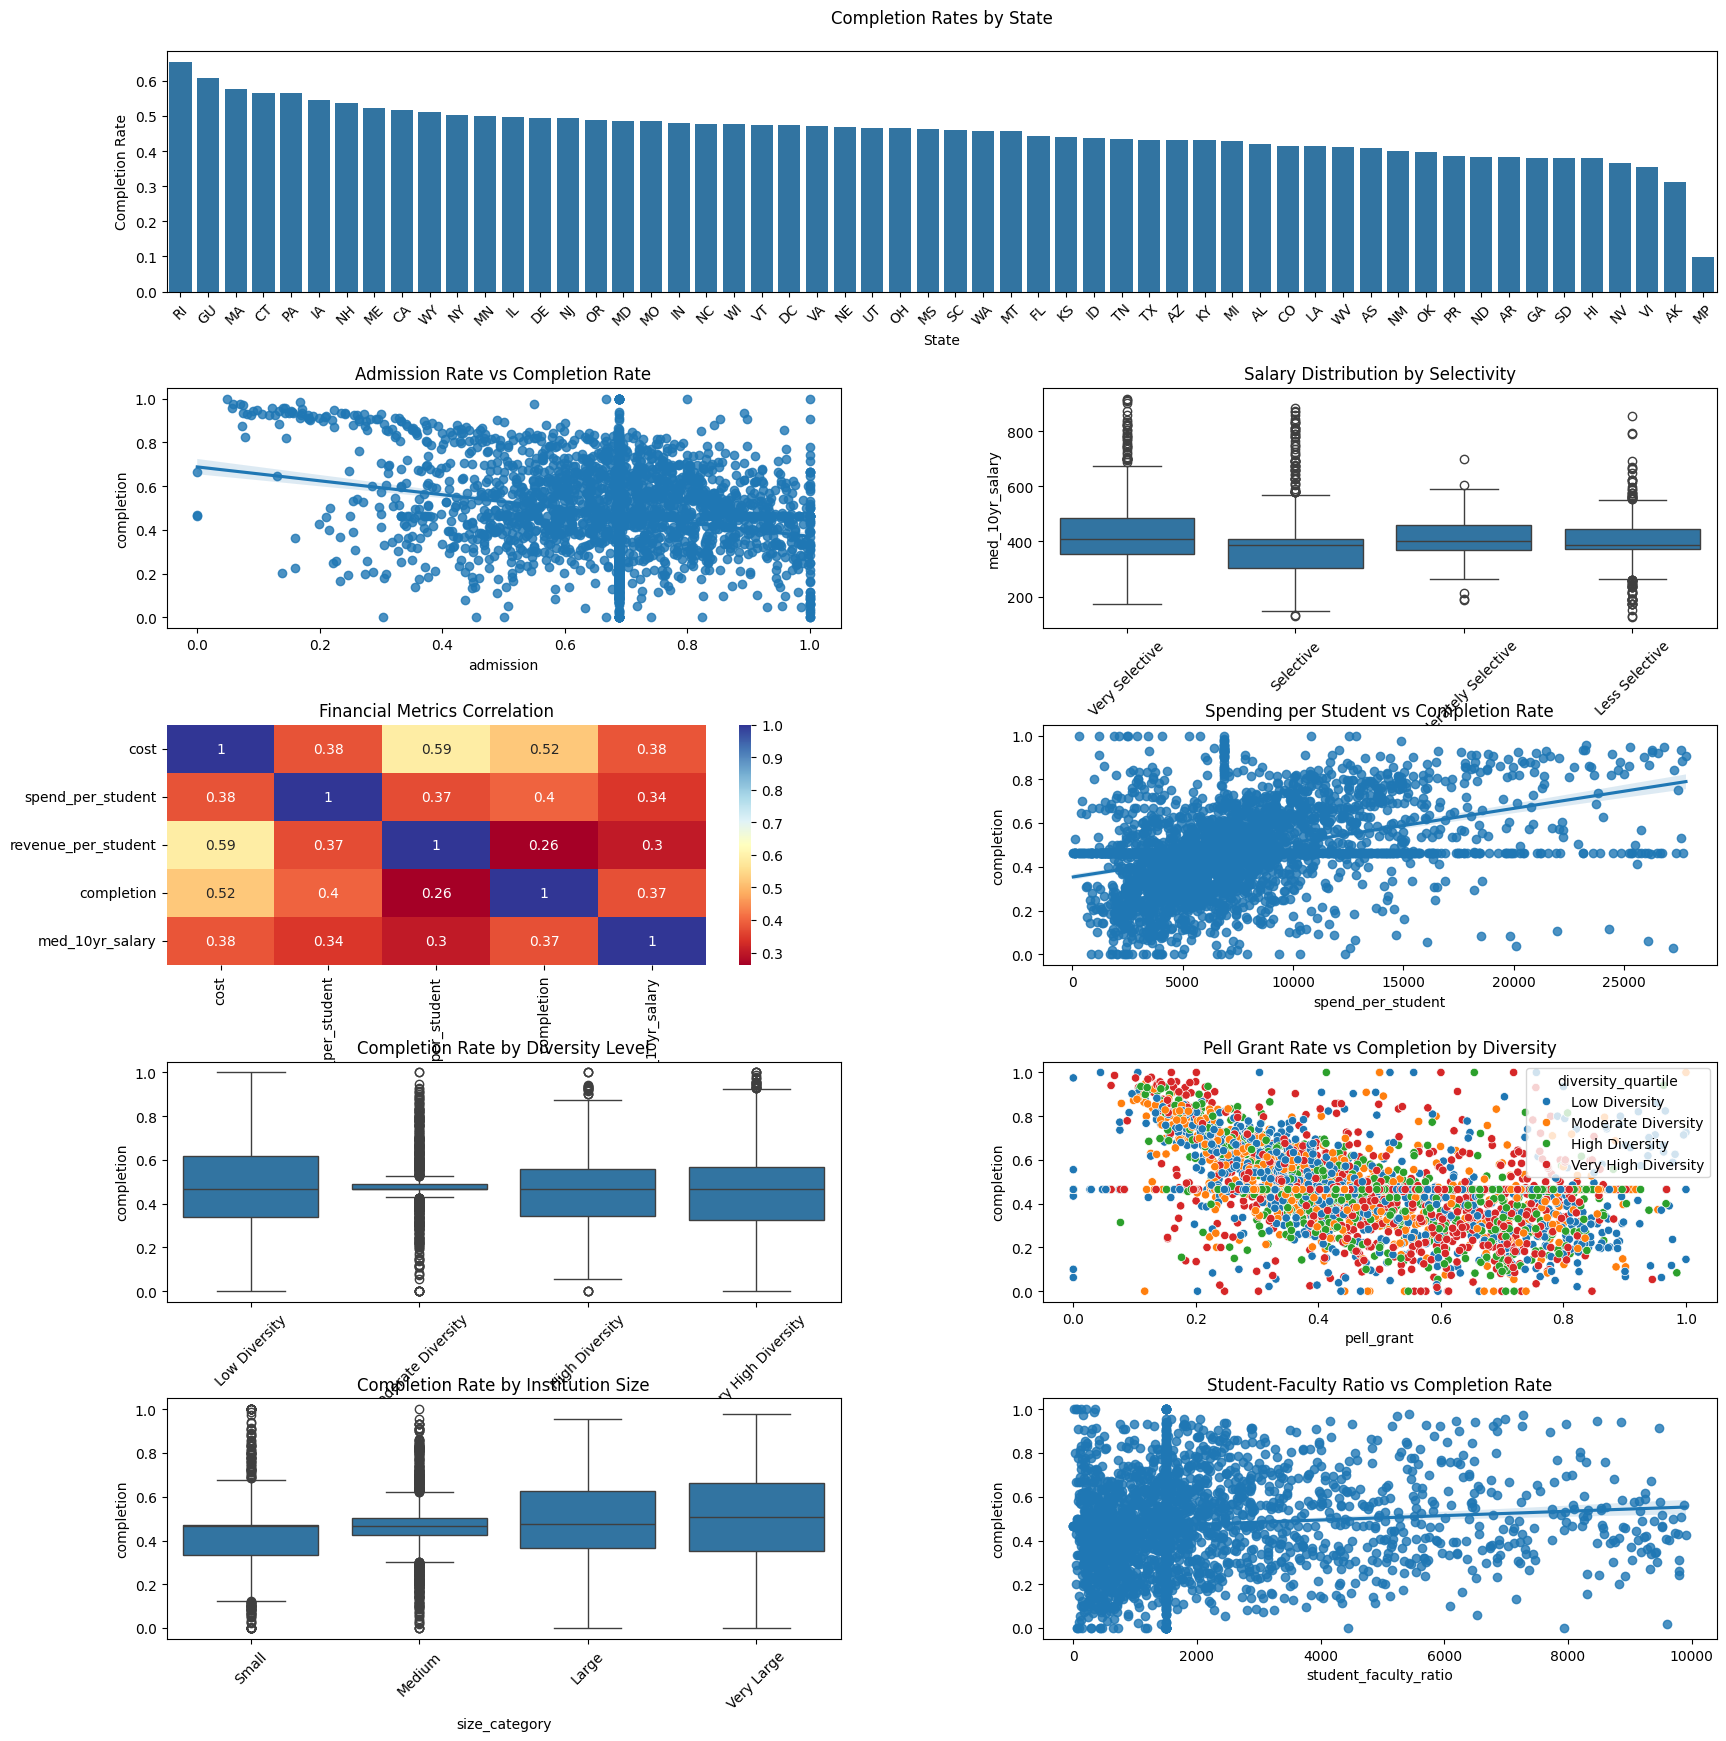

In [ ]:
# Create analyzer instance
analyzer = CollegeSuccessAnalysis('/content/college_scorecard (1).csv')

# Run the analysis
results = analyzer.main()